In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error

Using TensorFlow backend.


In [2]:
import pandas as pd
import quandl
import datetime
start = datetime.datetime(2006,1,1)
end = datetime.date.today()
amz = quandl.get("WIKI/AMZN", start_date=start, end_date=end)

In [3]:

amz.shape

(3077, 12)

In [4]:
# Some functions to help out with
def plot_predictions(test,predicted):
    plt.plot(test, color='red',label='Real Amazon Stock Price')
    plt.plot(predicted, color='blue',label='Predicted Amazon Stock Price')
    plt.title('Amazon Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('Amazon Stock Price')
    plt.legend()
    plt.show()

def return_rmse(test,predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))

In [5]:
amz.columns 

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Ex-Dividend', 'Split Ratio',
       'Adj. Open', 'Adj. High', 'Adj. Low', 'Adj. Close', 'Adj. Volume'],
      dtype='object')

In [6]:
columns = ['Open', 'High', 'Low', 'Close', 'Volume']
dataset = amz[columns].assign(Name='AMZN')
dataset.head()

,Open,High,Low,Close,Volume,Name
Date,,,,,,
2006-01-03,47.470,47.85,46.25,47.58,7582200.0,AMZN
2006-01-04,47.485,47.73,46.69,47.25,7440900.0,AMZN
2006-01-05,47.160,48.20,47.11,47.65,5417200.0,AMZN
2006-01-06,47.970,48.58,47.32,47.87,6152900.0,AMZN
2006-01-09,46.550,47.10,46.40,47.08,8943100.0,AMZN


In [7]:
training_set = dataset[:'2016'].iloc[:,1:2].values
test_set = dataset['2017':].iloc[:,1:2].values

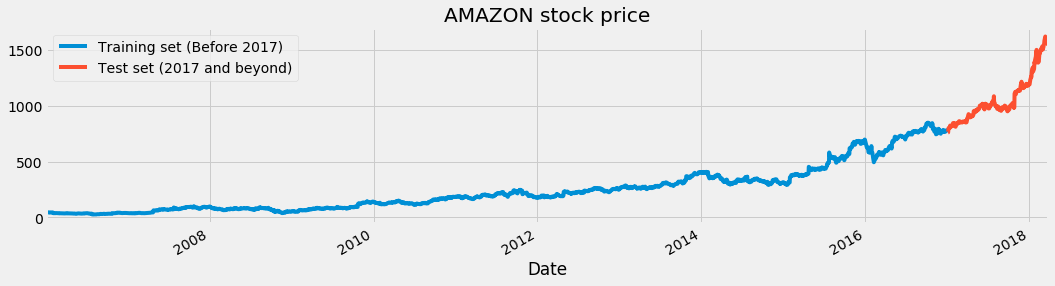

In [8]:
#We have chosen 'High' attribute for prices. Let's see what it looks like
dataset["High"][:'2016'].plot(figsize=(16,4),legend=True)
dataset["High"]['2017':].plot(figsize=(16,4),legend=True)
plt.legend(['Training set (Before 2017)','Test set (2017 and beyond)'])
plt.title('AMAZON stock price')
plt.show()

In [9]:
# Scaling the training set
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(training_set)

Since LSTMs store long term memory state, we create a data structure with 60 timesteps and 1 output. So for each element of training set, we have 60 previous training set elements

In [10]:
X_train = []
y_train = []
for i in range(60,2768):
    X_train.append(training_set_scaled[i-60:i,0])
    y_train.append(training_set_scaled[i,0])
X_train, y_train = np.array(X_train), np.array(y_train)

# Reshaping X_train for efficient modelling
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

In [ ]:
%%time
# The LSTM architecture
regressor = Sequential()
# First LSTM layer with Dropout regularisation
regressor.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
regressor.add(Dropout(0.2))
# Second LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))
# Third LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))
# Fourth LSTM layer
regressor.add(LSTM(units=50))
regressor.add(Dropout(0.2))
# The output layer
regressor.add(Dense(units=1))

# Compiling the RNN
regressor.compile(optimizer='rmsprop',loss='mean_squared_error')
# Fitting to the training set
regressor.fit(X_train,y_train,epochs=5,batch_size=32)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 1/5
2708/2708 [==============================] - 14s 5ms/step - loss: 0.0104
Epoch 2/5
2708/2708 [==============================] - 13s 5ms/step - loss: 0.0046
Epoch 3/5
2708/2708 [==============================] - 13s 5ms/step - loss: 0.0031
Epoch 4/5
2708/2708 [==============================] - 13s 5ms/step - loss: 0.0032
Epoch 5/5
2688/2708 [============================>.] - ETA: 0s - loss: 0.0026

In [25]:
dataset_total = pd.concat((dataset["High"][:'2016'],dataset["High"]['2017':]),axis=0)
inputs = dataset_total[len(dataset_total)-len(test_set) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = sc.transform(inputs)

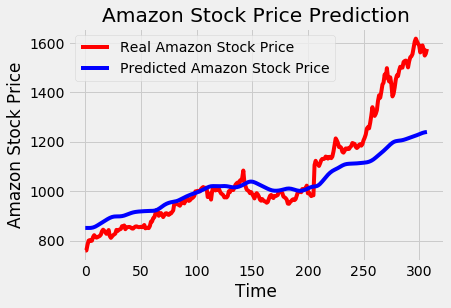

In [32]:
# Preparing X_test and predicting the prices
X_test = []
for i in range(60,368):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

# Visualizing the results for LSTM
plot_predictions(test_set,predicted_stock_price)


In [33]:
return_rmse(test_set,predicted_stock_price)

The root mean squared error is 128.11919975688272.


In [34]:
%%time
regressorGRU = Sequential()
# First GRU layer with Dropout regularisation
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Second GRU layer
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Third GRU layer
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Fourth GRU layer
regressorGRU.add(GRU(units=50, activation='tanh'))
regressorGRU.add(Dropout(0.2))
# The output layer
regressorGRU.add(Dense(units=1))
# Compiling the RNN
regressorGRU.compile(optimizer=SGD(lr=0.01, decay=1e-7, momentum=0.9, nesterov=False),loss='mean_squared_error')
# Fitting to the training set
regressorGRU.fit(X_train,y_train,epochs=5,batch_size=150)

Epoch 1/5
2708/2708 [==============================] - 9s 3ms/step - loss: 0.0716
Epoch 2/5
2708/2708 [==============================] - 6s 2ms/step - loss: 0.0256
Epoch 3/5
2708/2708 [==============================] - 7s 3ms/step - loss: 0.0042
Epoch 4/5
2708/2708 [==============================] - 7s 3ms/step - loss: 0.0026
Epoch 5/5
2708/2708 [==============================] - 6s 2ms/step - loss: 0.0022
CPU times: user 1min 38s, sys: 5.15 s, total: 1min 44s
Wall time: 39.1 s


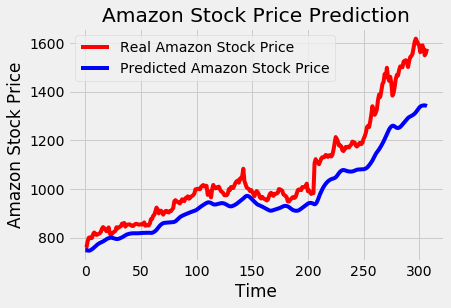

In [36]:
# Preparing X_test and predicting the prices
X_test = []
for i in range(60,368):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
GRU_predicted_stock_price = regressorGRU.predict(X_test)
GRU_predicted_stock_price = sc.inverse_transform(GRU_predicted_stock_price)

# Visualizing the results for GRU
plot_predictions(test_set,GRU_predicted_stock_price)

In [37]:
%%time
# The LSTM architecture
regressorLG = Sequential()
# First LSTM layer with Dropout regularisation
regressorLG.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
regressorLG.add(Dropout(0.2))
regressorLG.add(GRU(units=50, activation='tanh'))
regressorLG.add(Dropout(0.2))
# The output layer
regressorLG.add(Dense(units=1))
# Compiling the RNN
regressorLG.compile(optimizer=SGD(lr=0.01, decay=1e-7, momentum=0.9, nesterov=False),loss='mean_squared_error')
# Fitting to the training set
regressorLG.fit(X_train,y_train,epochs=5,batch_size=150)

Epoch 1/5
2708/2708 [==============================] - 4s 1ms/step - loss: 0.0600
Epoch 2/5
2708/2708 [==============================] - 3s 1ms/step - loss: 0.0176
Epoch 3/5
2708/2708 [==============================] - 3s 1ms/step - loss: 0.0038
Epoch 4/5
2708/2708 [==============================] - 3s 1ms/step - loss: 0.0021
Epoch 5/5
2708/2708 [==============================] - 3s 1ms/step - loss: 0.0019
CPU times: user 49 s, sys: 2.88 s, total: 51.8 s
Wall time: 18.2 s


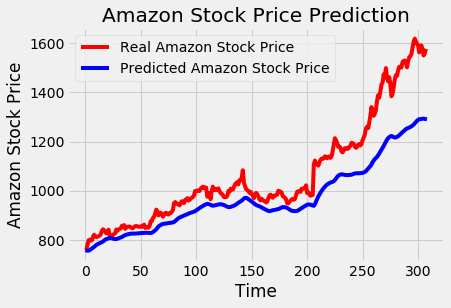

In [45]:
dataset_total = pd.concat((dataset["High"][:'2017'],dataset["High"]['2018':]),axis=0)
inputs = dataset_total[len(dataset_total)-len(test_set) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = sc.transform(inputs)

# Preparing X_test and predicting the prices
X_test = []
for i in range(60,369):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
LG_predicted_stock_price = regressorLG.predict(X_test)
LG_predicted_stock_price = sc.inverse_transform(LG_predicted_stock_price)

# Visualizing the results for GRU
plot_predictions(test_set,LG_predicted_stock_price)